# Data Fitting

There are many cases in physics where you have some data and you want to describe that data by some mathematical function, or more generally, some model of that data. While you can immediately jump into a linear regression or polynomial regresssion, this is often not the best approach. Many times a simple line fit, or function fit, will give you more satifying results.

First, we make some quasi data so we have something to play with. I will start with some data that has a simple linear trend with some random scatter around the trend. We will use (and repeat) some of the information that is in the [05_Random_Numbers](https://github.com/mholtrop/Phys601/blob/master/Notebooks/05_Random_Numbers.ipynb) notebook.

In [5]:
# import the usual packages.
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

Define a simple line function, and throw some random points, evaluate the function at those points, and add some randomness to these points.

There is something to be carefull about though everytime you do a fit. You need to know the *uncertainty* (or the error) in each of your input data points in order to get the correct uncertainty about how good the fit was, and in order to get a proper estimate of the error on the fitted parameters. I will say more about that later. For now, we choose a certain $\sigma$ for each datapoint which is equal to the $\sigma$ of the normal distribution by which we spread our data out.

Below we create the data function, call it N time with 

In [84]:
def data_function(x):
    return( 5.7 + 3.2*x)

<ErrorbarContainer object of 3 artists>

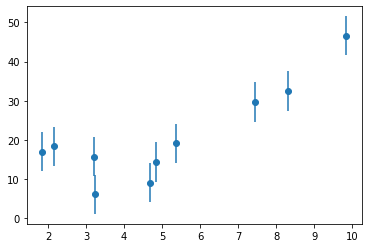

In [93]:
data_sigma = 5.
N = 10
x_data = np.sort(np.random.random(N)*10)  # Ten points at random places between 0 and 10, sorted in order.
y_data = data_function(x_data) + np.random.normal(0,5.,len(x_data)) # Data with some random on each point.
y_data_err = np.array([5.]*len(x_data))
plt.errorbar(x_data,y_data,yerr=y_data_err,fmt='o') # Plot the result, to check it makes sense.

## Simple line fit

The easiest model to fit your data with is a line. To compute the slope and $x=0$ intercept, you actually don't need to do a "fit", you can simply take averages, see the [05_Random_Numbers](https://github.com/mholtrop/Phys601/blob/master/Notebooks/05_Random_Numbers.ipynb) notebook. Here I will repeat the method for fitting a line using the *least squares fitting method*.

First we need to difine the functional form of the fit. For a line this is just $y = a + b x$, defining the function:

In [94]:
def fit_func(x,a,b):
    return(a + b*x)

Next we do a simple fit of the line to our data. This is done with `scipy.optimize.curve_fit(function,x,y)`. The result will be a list of the function paramters (in our case [a,b]) and the *covariant matrix*, which I will discuss below.

Found a =  1.7850 ± 25.4227  b=  3.7432 ±  0.7835


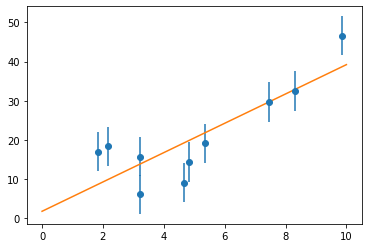

In [95]:
import scipy.optimize as opt
pars, covar = opt.curve_fit(fit_func,x_data,y_data,sigma=y_data_err)
print("Found a = {:7.4f} ± {:7.4f}  b= {:7.4f} ± {:7.4f}".format(pars[0],covar[0,0],pars[1],covar[1,1]))
plt.errorbar(x_data,y_data,yerr=y_data_err,fmt='o') # Plot the result, to check it makes sense.
x = np.linspace(0,10,1000)
plt.plot(x,fit_func(x,*pars)) # Plot the resulting function.

So, we found a line that looks reasonable compared to the points, and we even got errors on the estimated parameters. But, how "good" was the fit? Did we fit the data with the appropriate model, and used the correct number of unknowns to fit for?

This clearly gets more tricky, and here we get a bit more into the fine points of data fitting. There are two useful papers that I found with a quick web search:
* Chi-square testing for goodness of fit. (Peter Scott, UCSC)[Chapter 4](http://physics.ucsc.edu/~drip/133/ch4.pdf) also usefull is [Chapter 2](http://physics.ucsc.edu/~drip/133/ch2.pdf) and [Chapter 3](http://physics.ucsc.edu/~drip/133/ch3.pdf)
* Do's and don'ts ofreduced chi-square fitting. [arXiv:1012.3754v1](https://arxiv.org/pdf/1012.3754.pdf)

First, we need to introduce the idea of the $\chi^2$ (chi-squared) as a measure of the "goodness of fit". Here unfortunately you will find two different definitions. The statisticians (and other non-physics folks) seem to use:

$$ \chi^2 = \sum_{i=0}^N \frac{ \left(y_i - m_i \right)^2}{m_i^2} $$

Where $y_i$ is the observed value in your data sample, and $m_i$ is the predicted value. ([See Wikipedia](https://en.wikipedia.org/wiki/Chi-squared_test). This does work for minimization, but it does not take into account the uncertainty in each measurement point. 

In Physics, we use a different definition of $\chi^2$:

$$ \chi^2 = \sum_{i=0}^N \frac{ \left(y_i - m_i \right)^2}{\sigma_i^2} $$

where $\sigma_i$ is the measurement uncertainty for the $i$ value of the measurements, $y_i$. This weighs each difference between measurement and prediction by the uncertainty in the measurement, so very uncertain points don't incorrectly skew the fit.

An important thing to note is that this type of chi-squared minimization is strictly speaking only correct for errors that have a Gaussian (or normal) distribution. I.e. the uncertainty in each point has a Gaussian shaped distribution. This is so common in physics data that we tend to take it for granted, but we should not. (I.e. for many experiments, the measurement is in "counts", and the error will be the square root of the counts.)

The other item that comes into play is the *number of degrees of freedom* in the problem. This is typically the number of data points in your fit, minus the number of parameters in your fit, so:

$$ N_{df} = N_s - N_p $$

The *reduced chi-squared* is then found as $\chi^2_R = \chi^2 / N_{df}$.

The rule of thumb is that you have a perfect fit when the reduced chi-squared $\chi^2_R \approx 1$. A big $\chi^2_R$ means that you don't describe your data well, or your errors were under-estimated, a small $\chi^2_R$ means that you are possibly over fitting the data, or your errors are larger than the variation in your data.

Note however, that the $\chi^2$ (and thus $\chi^2_R$) forms a distribution. If you were to repeat your experiment many, many times, and fit with the same model, you would end up with a distribution of $\chi^2$ with a mean of $N_{df}$, or alternatively a distribution of $\chi^2_R$ with a mean of 1. The chi-squared *probabiloty distribution* is given by the function:

$$\mathrm{prob}(\chi^2,\nu) = \frac{1}{2^{\nu/2} \Gamma\left(\nu/2\right)}\left(\chi^2\right)^{(\nu/2-1)} e^{-\chi^2/2}$$ 

Let's try this.

In [107]:
def compute_chi_squared(x_data,y_data,y_data_err,model,pars):
    """Compute the chi-squared and the reduced chi-squared.
    x_data: points are which y_data samples occur.
    y_data: the data points of the experiment. 
    y_data_err: the errors on the y_data points.
    model: the function used for fitting. 
    pars: a list of parameters for the model function.
    Returns a tuple: (chi-squared, reduced-chi-squared)"""
    # As a loop, you would do the following:
    #chisq = 0
    #for xx,yy,ye in zip(x_data,y_data,y_data_err):
    #    chisq += (model(xx,*pars)-yy)**2/ye**2
    # Using Numpy style computing is much faster:
    chisq = np.sum((fit_func(x_data,*pars) - y_data)**2 / y_data_err**2)
    reduced_chisq = chisq/(len(x_data) - len(pars))
    return (chisq,reduced_chisq)

In [108]:
my_chisq,my_chisq_R = compute_chi_squared(x_data,y_data,y_data_err,fit_func,pars)
print("The chi-squared divided by the number of degrees of freedom is ",my_chisq_R)

The chi-squared divided by the number of degrees of freedom is  2.04381183122542


Now to get a chi-squared distrinbution, we need to do the whole thing, from data generation to fitting to chi-squared computation, over and over for a large number of times, and then make a normalized histogram of the resulting chi-squares. 

Let's do it and look at the result:

In [134]:
# Define the chi-squared pobability function:
def prob_chi(chi2,Ndf):
    return 1/(2**(Ndf/2)*math.gamma(Ndf/2)) * ((chi2)**(Ndf/2 -1))*np.exp(-chi2/2)

In [121]:
M = 10000  # Number of "experiments" we run.
chi_store = []  # This will become the list of chi-squared values.
for m_num in range(M):
    # Run an "experiment", to get the data.
    x_data = np.sort(np.random.random(N)*10)  # Ten points at random places between 0 and 10, sorted in order.
    y_data = data_function(x_data) + np.random.normal(0,5.,len(x_data)) # Data with some random on each point.
    y_data_err = np.array([5.]*len(x_data))
    # Now fit that data
    pars, covar = opt.curve_fit(fit_func,x_data,y_data,sigma=y_data_err)
    # Next compute the chi-squared, and store the result.
    chisq, chisq_r = compute_chi_squared(x_data,y_data,y_data_err,fit_func,pars)
    chi_store.append(chisq)

Distribution mean:  7.9862839276595725


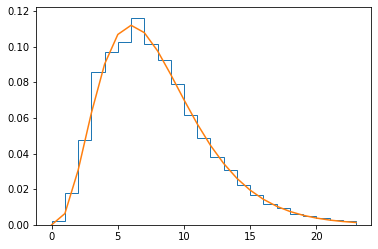

In [136]:
print("Distribution mean: ",np.mean(chi_store))
Ndf = len(x_data) - len(pars)

counts, bins, patches = plt.hist(chi_store,np.arange(0,24,1),histtype="step",density=True)
plt.plot(bins,prob_chi(bins,Ndf))

Note that the mean is indeed the $N_{df}$ of the problem, and indeed the chi-square probabilty function accurately describes our result.



# Linear Regressions and Beyond.

Some later time, I wil fill this in....